In [155]:
import numpy as np
import matplotlib.pyplot as plt

Generate Uniform Linear Array (ULA)

In [156]:
def get_correlated_ULA(el, L, N, p, sVar=10, phi=None, d=None, f0=2.4e9, r0=0):
    # Prepare inputs
    el = np.deg2rad(el)
    lambd = 300e6 / f0
    if d is None:
        d = lambd / 2
    M = len(el)

    # Generate URA positions
    r = np.zeros(L)
    for i in range(L):
        r[i] = i * d + r0

    # Generate signal s(t)
    Pxx = np.ones((M, M)) * p               # Set elements equal to p
    Pxx[np.diag_indices_from(Pxx)] = 1      # Set diagonal equal to 1

    print(Pxx)

    #s = np.sqrt(sVar) * np.random.multivariate_normal(np.zeros(M), Pxx, size=(M, 2*N)).view(np.complex128)[:, :, 0]
    s = (np.sqrt(sVar) * np.random.multivariate_normal(np.zeros(M), Pxx, size=(M, N)) + 1j * np.random.multivariate_normal(np.zeros(M), Pxx, size=(M, N)))[:, :, 0]
    
    print(np.random.multivariate_normal(np.zeros(M), Pxx, size=(M, N)).shape)
    print(s.shape)

    # Generate steering matrix A(el, az)
    A = np.zeros((L, M), dtype=np.complex128)
    for m in range(M):
        A [:, m] = np.exp(2j * np.pi * np.arange(L) * d / lambd * np.cos(el[m]))

    x = A @ s

    return x, r

def get_noise(x, SNR_dB=5):
    L, N = x.shape
    SNR = 10.0**(SNR_dB / 10.0) # Desired linear SNR
    xVar = x.var() # Power of signal
    nVar = xVar / SNR # Desired power of noise
    n = np.random.normal(0, np.sqrt(nVar*2.0)/2.0, size=(L, 2*N)).view(complex)
    print(10 * np.log10(xVar / n.var()))
    return n

def MUSIC_beamforming(x, r, M, resolution=None, f0=2.4e9):
    L, N = x.shape
    if resolution is None:
        resolution = 2 * N
    el_search = np.linspace(start=0, stop=np.pi, num=resolution, endpoint=True)
    lambd = 300e6 / f0      # Wavelength
    d = r[1] - r[0]         # ULA element distance
    r0 = r[0]               # Position of first sensor

    # Compute correlation of the signal
    Rxx = x @ x.conj().T / N

    # Eigenvalue decomposition
    eig_vals, eig_vecs = np.linalg.eig(Rxx)

    # Create indexation array for descenting values
    idx = np.argsort(eig_vals)
    
    # Sort eigs with indexation array
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:, idx]
    
    # Create Un with L-M least noise eigenvectors
    Un = eig_vecs[:, 0:(L-M)]

    A = np.zeros((L, resolution), dtype=np.complex128)       # Steering matrix solution
    P_MUSIC = np.zeros(resolution, dtype=np.complex128)   # MUSIC solution
    for n in range(resolution):
        A[:,n] = np.exp(2j * np.pi * np.arange(L) * ((d / lambd) + r0) * np.cos(el_search[n]))
        #A[:,n] = np.exp(1j * np.pi * (np.arange(L) * np.cos(theta_search[n])))
        P_MUSIC[n] = 1 / (A[:,n].conj().T @ Un @ Un.conj().T @ A[:,n])

    return P_MUSIC, np.rad2deg(el_search)

def normalize(arr):
    abs_arr = np.abs(arr.real)
    norm_arr = (abs_arr - np.min(abs_arr)) / (np.max(abs_arr) - np.min(abs_arr))
    return norm_arr

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
(3, 100, 3)
(3, 100)
5.181125101190043


(40.0, 50.0)

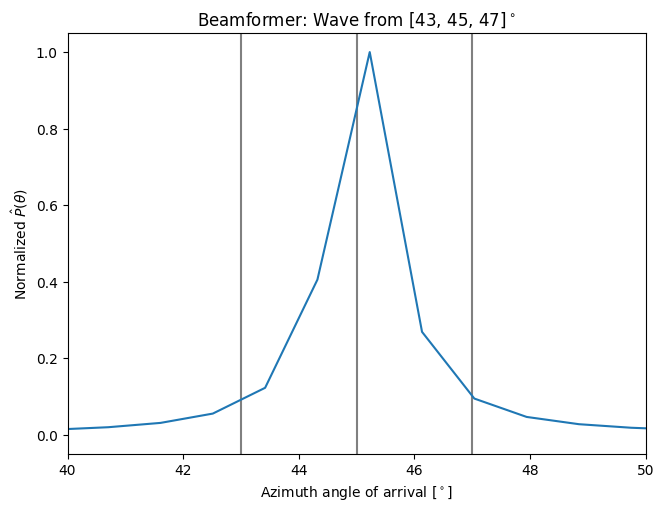

In [173]:
el = [43, 45, 47]   # Impinging waves
L = 8          # Number of elements in ULA
N = 100         # Number of observations
p = 1         # Correlation factor: (Uncorrelated) 0 <= p <= 1 (Correlated)

x, r = get_correlated_ULA(el, L, N, p)
x += get_noise(x, 5)
Pm, el_music = MUSIC_beamforming(x, r, len(el))

# Plot solution
fig, ax = plt.subplots()
for theta in el:
    ax.axvline(x = theta, color='gray')
fig.tight_layout()
ax.plot(el_music, normalize(Pm), label='MUSIC')
ax.set_title(f'Beamformer: Wave from {el}$^\\circ$')
ax.set_ylabel('Normalized $\hat{P}(\\theta)$')
ax.set_xlabel('Azimuth angle of arrival [$^\\circ$]')
ax.set_xlim([40, 50])
